In [21]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ot
import cvxpy as cp

# Supplementary Packages
#import scipy.stats as stats
import seaborn as sns
#import scipy.special as sps
#import time as t

## Functions

In [22]:
def baryc_proj(source, target, method = 'emd'):
    
    n1 = source.shape[0]
    n2 = target.shape[0]   
    p = source.shape[1]
    a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    
    M = ot.dist(source, target)
    M = M.astype('float64')
    M /= M.max()
    
    if method == 'emd':
        OTplan = ot.emd(a_ones, b_ones, M, numItermax = 1e7)
        
    elif method == 'entropic':
        OTplan = ot.bregman.sinkhorn_stabilized(a_ones, b_ones, M, reg = 5*1e-3)
    
    # initialization
    OTmap = np.empty((0, p))

    for i in range(n1):
        
        # normalization
        OTplan[i,:] = OTplan[i,:] / sum(OTplan[i,:])
    
        # conditional expectation
        OTmap = np.vstack([OTmap, (target.T @ OTplan[i,:])])
    
    OTmap = np.array(OTmap)
    
    return(OTmap)

In [23]:
def DSCreplication(target, controls, method = 'emd'):
    
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    S = np.mean(target)*n*d*J #Stabilizer: to be used for optimization
    
    
    # Barycentric Projection
    G_list = []
    proj_list = []
    for i in range(len(controls)):
        temp = baryc_proj(target, controls[i], method)
        G_list.append(temp)
        proj_list.append(temp - target)
    
    
    # Obtain optimal weights
    mylambda = cp.Variable(J)

    objective = cp.Minimize(
                    cp.sum(
                    cp.sum(
                    cp.sum([a*b for a,b in zip(mylambda, proj_list)])**2))/S
                    )
    
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    weights = mylambda.value
    replication = sum([a*b for a,b in zip(weights, G_list)])
    
    
    return(weights, replication)

## Mixed Multivariate Normal

In [24]:
def mixed_multi_gauss(mean1, mean2, mean3, cov1, cov2, cov3, samplesize, partition1, partition2):
    
    size1 = int(samplesize * partition1)
    size2 = int(samplesize * partition2)
    size3 = int(samplesize - size1 - size2)
    
    gauss1 = np.random.multivariate_normal(mean = mean1, cov = cov1, size = size1)
    gauss2 = np.random.multivariate_normal(mean = mean2, cov = cov2, size = size2)
    gauss3 = np.random.multivariate_normal(mean = mean3, cov = cov3, size = size3)
    
    mixed = np.concatenate((gauss1, gauss2, gauss3), axis = 0)
    np.random.shuffle(mixed)
    
    return(mixed)

def multi_gauss_mix(gauss_set, partition1, partition2):
    
    mixed = np.concatenate(gauss_set, axis = 0)
    np.random.shuffle(mixed)
    
    return(mixed)

In [25]:
dim = 10
obs = 1000

mu1 = [10]*dim
mu2 = [50]*dim
mu3 = [200]*dim
mu4 = [-50]*dim
mu5 = [-10]*dim

covmat = np.full((dim, dim), 0.5)
np.fill_diagonal(covmat, 1)

X1 = np.random.multivariate_normal(mean = mu1, cov = covmat, size = obs)
X2 = np.random.multivariate_normal(mean = mu2, cov = covmat, size = obs)
X3 = np.random.multivariate_normal(mean = mu3, cov = covmat, size = obs)
X4 = np.random.multivariate_normal(mean = mu4, cov = covmat, size = obs)

Y1 = mixed_multi_gauss(mu1, mu2, mu3, covmat, covmat, covmat, obs, 0.3, 0.6) #50
Y2 = mixed_multi_gauss(mu1, mu2, mu3, covmat, covmat, covmat, obs, 0.8, 0.1) #33
Y3 = mixed_multi_gauss(mu2, mu3, mu4, covmat, covmat, covmat, obs, 0.2, 0.7) #145
Y4 = mixed_multi_gauss(mu1, mu3, mu4, covmat, covmat, covmat, obs, 0.2, 0.2) #12

In [26]:
weightsx, replicationx = DSCreplication(X1, [X2, X3, X4]) # check
weightsx

array([0.35857968, 0.09665741, 0.54476292])

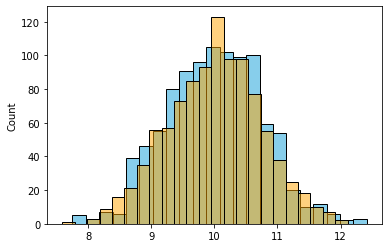

In [27]:
sns.histplot(np.mean(X1, axis = 1), color = 'skyblue', alpha = 1)
sns.histplot(np.mean(replicationx, axis = 1), color = 'orange', alpha = 0.5)

plt.savefig('4_1X.png')

In [28]:
weightsy, replicationy = DSCreplication(Y1, [Y2, Y3, Y4])
weightsy

array([ 8.20450242e-01,  1.79549758e-01, -1.47513026e-16])

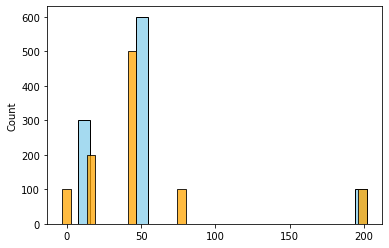

In [32]:
sns.histplot(np.mean(Y1, axis = 1), color = 'skyblue')
sns.histplot(np.mean(replicationy, axis = 1), color = 'orange')

plt.savefig('4_1Y.png')

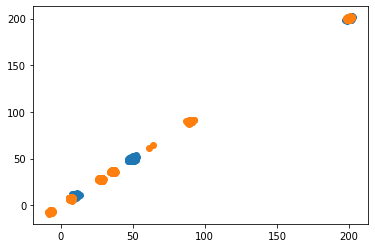

In [203]:
# alternative plot
## pick 2 dimensions that look best

ax1 = plt.scatter(Y1[:,3], Y1[:,9])
plt.scatter(replicationy[:,3], replicationy[:,9])

(array([300.,   0., 600.,   0.,   0.,   0.,   0.,   0.,   0., 100.]),
 array([  8.02250567,  27.35672356,  46.69094146,  66.02515935,
         85.35937725, 104.69359514, 124.02781303, 143.36203093,
        162.69624882, 182.03046672, 201.36468461]),
 <BarContainer object of 10 artists>)

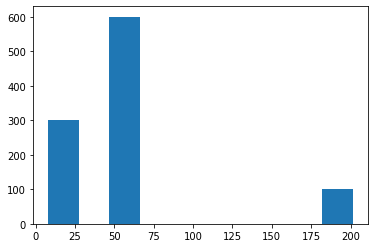

In [184]:
plt.hist(np.mean(Y1, axis = 1))

(array([800.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0., 100.]),
 array([  7.71330489,  27.14431141,  46.57531794,  66.00632446,
         85.43733099, 104.86833751, 124.29934404, 143.73035056,
        163.16135709, 182.59236361, 202.02337014]),
 <BarContainer object of 10 artists>)

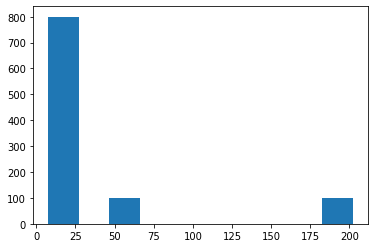

In [183]:
plt.hist(np.mean(Y2, axis = 1))

(array([100.,   0.,   0., 117.,  83.,   0.,   0.,   0.,   0., 700.]),
 array([-52.03964247, -26.50437091,  -0.96909935,  24.56617221,
         50.10144378,  75.63671534, 101.1719869 , 126.70725847,
        152.24253003, 177.77780159, 203.31307315]),
 <BarContainer object of 10 artists>)

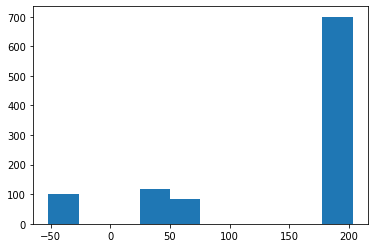

In [9]:
plt.hist(np.mean(Y3, axis = 1))

(array([600.,   0., 200.,   0.,   0.,   0.,   0.,   0.,   0., 200.]),
 array([-52.34625048, -26.89203945,  -1.43782842,  24.01638262,
         49.47059365,  74.92480468, 100.37901572, 125.83322675,
        151.28743778, 176.74164881, 202.19585985]),
 <BarContainer object of 10 artists>)

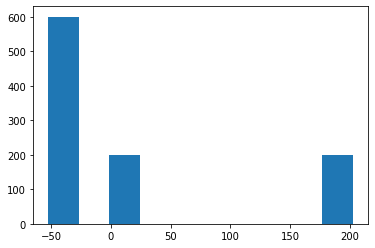

In [204]:
plt.hist(np.mean(Y4, axis = 1))